In [1]:
import os 
import glob
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage import io
from tqdm import tqdm

from utils.utils import read_csv, load_config
from measurements.measurements import get_function_dict

In [2]:
def plot_image(image, landmarks, labels=None, sizes=None, colors=None, alpha=0.5):

    fig, ax = plt.subplots()
    plt.imshow(image, cmap='gray')
        
    ax_scat = ax.scatter(landmarks[:, 1], landmarks[:, 0], c=colors, s=sizes, alpha=alpha)
    fig.colorbar(ax_scat, ax=ax)

    if not labels is None:
        for landmark, label in zip(landmarks, labels):
            plt.text(landmark[1], landmark[0], label[0])

# Distance Calculation and Plots

In [5]:
eval_reference = True # for "False", the target id is evaluated

# Load config and landmark names
config_tag = 'knee_axial_right_extra'
config = load_config(config_tag, config_path=r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\roma_medical\experiment_config_windows.json')
_, kpt_names = get_function_dict(config['mode'])

# exlude ids
exclude_ids = ['1000000001335799_0000117190_Y_LEFT', # one landmark missing
               '1000000001088769_9191304201_LATERAL_EXTRA_LEFT', # one landmark missing
               '1010500001896852_0000623603_AP_EXTRA_LEFT', # measurement (Felix) faulty?
               ]
               
# Find files and process
pred_files = []
for folder in config['experiment_folders']:
    pred_files.extend(glob.glob(os.path.join(config['experiment_root'], folder, '*matches.csv')))
print('{0} prediction files found...'.format(len(pred_files)))

annotation_files = []
for annotation_path in config['annotation_paths']:
    annotation_files.extend(glob.glob(os.path.join(annotation_path, '*_landmarks.csv')))
print('{0} annotation files found...'.format(len(annotation_files)))

individual_results = {}
for pred_file in tqdm(pred_files):

    # print(f'Processing {pred_file}...')

    # identify corresponding ground truth annotation file
    ids = os.path.split(pred_file)[-1].replace('_matches.csv','').split('_to_')

    if ids[0] in exclude_ids or ids[1] in exclude_ids:
        #print(f'Excluding {ids[0]} to {ids[1]}.')
        continue

    source_file = [f for f in annotation_files if os.path.split(f)[-1].startswith(f'{ids[1]}_')]
    if len(source_file)==0:
        print(f'Skipping {ids[0]} to {ids[1]} - no annotations found.')
        continue
    source_file = source_file[0]

    if eval_reference:
        individual_label = f'{ids[0]}'
    else:
        individual_label = f'{ids[1]}'

    # make sure a key for the current source file exits in the result dict
    individual_results.setdefault(individual_label, {})
    
    # load prediction and ground truth
    prd_kpts = read_csv(pred_file)
    prd_kpts = np.array([[float(x),float(y)] for x,y in prd_kpts])
    src_kpts = read_csv(source_file)
    src_kpts = np.array([[float(x)*config['landmark_scaling'][1],float(y)*config['landmark_scaling'][0]] for x,y in src_kpts])

    #print([f'{p} / {s}' for p,s in zip(prd_kpts,src_kpts)])

    # calculate distances
    dists = np.linalg.norm(src_kpts-prd_kpts, axis=1)
    dists[prd_kpts[:,0]==0] = np.nan
    
    # save distances to array
    for d,label in zip(dists, kpt_names):
        individual_results[individual_label].setdefault(' - '.join(label), [])
        individual_results[individual_label][' - '.join(label)].append(d)

380 prediction files found...
20 annotation files found...


100%|██████████| 380/380 [00:00<00:00, 1319.72it/s]


In [6]:
# Find reference patient with the lowest mean error
mean_dists = {}
for key in individual_results.keys():
    dist_dataframe = pd.DataFrame(individual_results[key])
    mean_value = dist_dataframe.mean().mean()
    mean_dists[key] = mean_value

# Sort results and save dict as json
sorted_mean_dists = {k: v for k, v in sorted(mean_dists.items(), key=lambda item: item[1])}
json_path = os.path.join(config['experiment_root'], config['experiment_folders'][0], f'reference_distances_{config_tag}.json')
with open(json_path, 'w') as f:
    json.dump(sorted_mean_dists, f, indent=4)

# Print results
print('Out of {0} samples...'.format(len(individual_results)))
lowest_key = list(sorted_mean_dists.keys())[0]
lowest_value = mean_dists[lowest_key]
lowest_value_cm = lowest_value*config['mpp']
print(f'Best key "{lowest_key}" with mean distance {lowest_value:.2f} ({lowest_value_cm:.2f} mm)')
highest_key = list(sorted_mean_dists.keys())[-1]
highest_value = mean_dists[highest_key]
highest_value_cm = highest_value*config['mpp']
print(f'Worst key "{highest_key}" with mean distance {highest_value:.2f} ({highest_value_cm:.2f} mm)')

Out of 20 samples...
Best key "1010500001095031_9190566102_AXIAL_EXTRA_RIGHT" with mean distance 73.99 (10.95 mm)
Worst key "1010500001724872_9191534902_AXIAL_EXTRA_RIGHT" with mean distance 164.82 (24.39 mm)


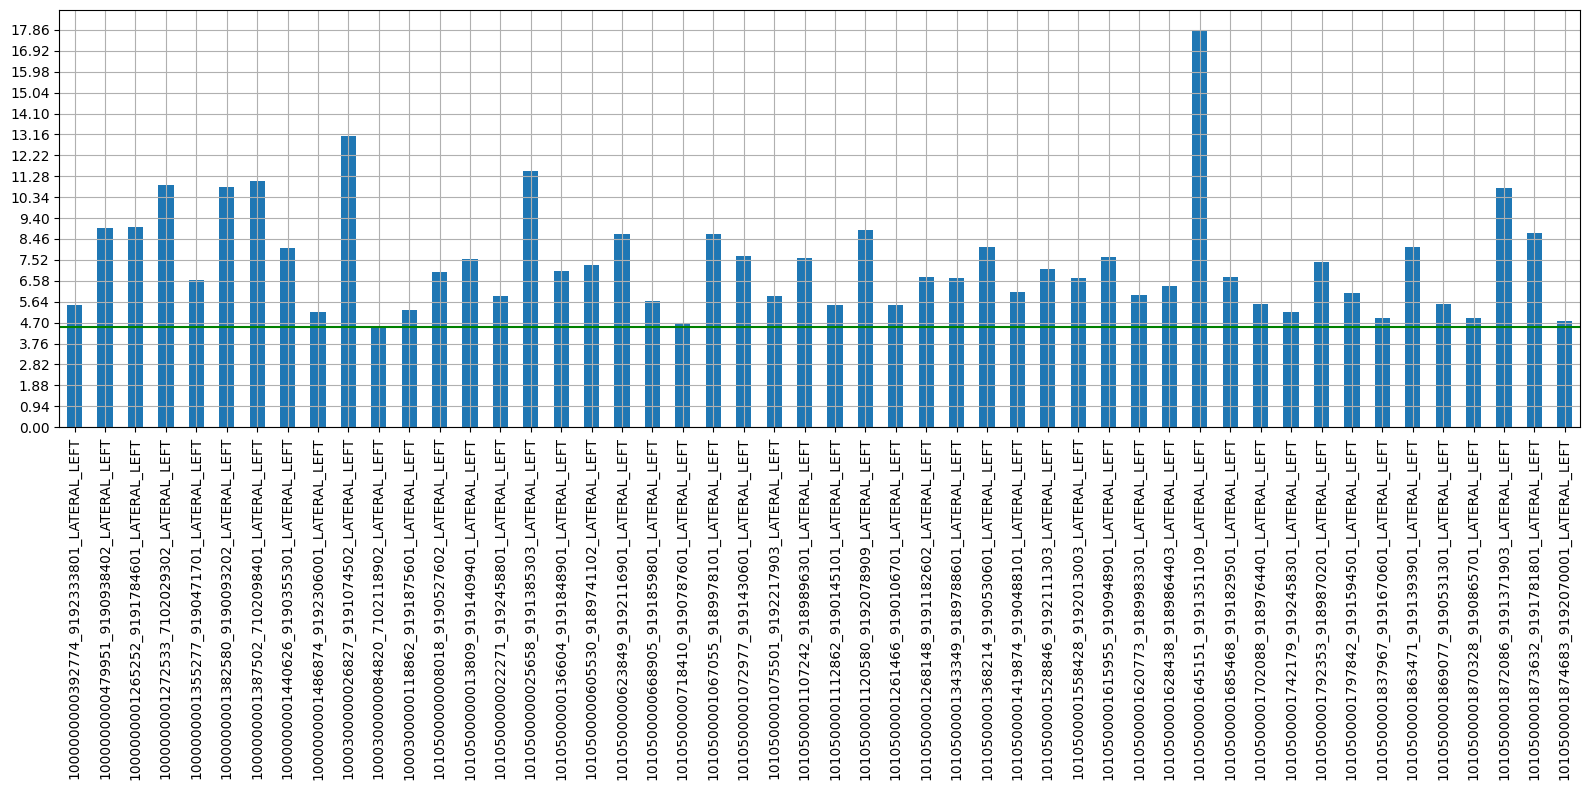

In [75]:
# Plot mean value of all reference patients
yticks = np.linspace(0, highest_value, 20)
dist_df = pd.DataFrame.from_dict(mean_dists, orient='index', columns=['value'])
dist_df = dist_df.sort_index()
dist_df.plot(kind='bar', legend=False, grid=True, figsize=[16,8])
plt.axhline(y=lowest_value, color='green', linestyle='-')
plt.xticks(rotation=90)
plt.yticks(yticks, labels=[f'{t:.2f}' for t in yticks*config['mpp']])
plt.tight_layout()
plt.show()

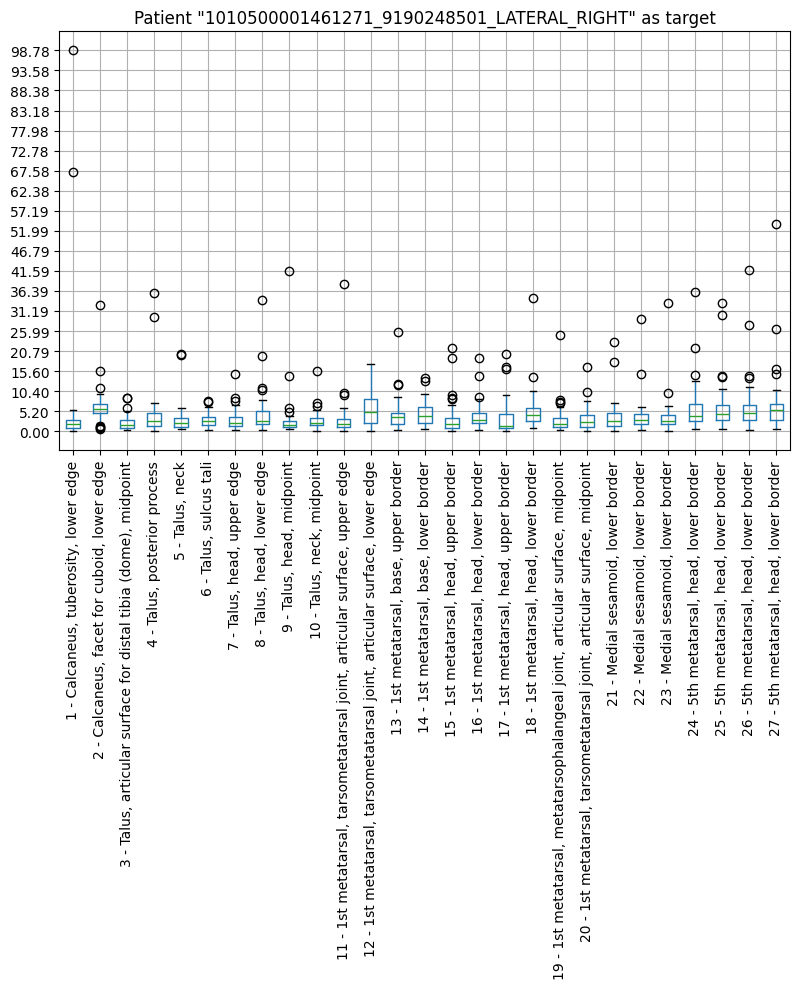

In [8]:
# Plot detailed results of best reference patient
dist_dataframe = pd.DataFrame(individual_results[lowest_key])
dist_dataframe.boxplot(rot=90, fontsize=10, figsize=[dist_dataframe.shape[1]*0.3,10])
yticks = np.linspace(0, dist_dataframe.max().max(), 20)
plt.xticks(rotation=90)
plt.yticks(yticks, labels=[f'{t:.2f}' for t in yticks*config['mpp']])
plt.title('Patient "{0}" as {1}'.format(lowest_key, 'reference' if eval_reference else 'target'))
plt.tight_layout()
plt.show()